In [1]:
# =============================================================================
# TP-TD4 : Analyse de Régression Multiple (Version Révisée)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# -----------------------------------------------------------------------------
# 1. PRÉPARATION DES DONNÉES (Utilisation de Pandas pour la structure)
# -----------------------------------------------------------------------------

data = {
    't':  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    'y':  [12, 14, 10, 16, 14, 19, 21, 19, 21, 16, 19, 21, 25, 21],
    'x1': [2, 1, 3, 6, 7, 8, 8, 5, 5, 8, 4, 9, 12, 7],
    'x2': [45, 43, 43, 47, 42, 41, 32, 33, 41, 38, 32, 31, 35, 29],
    'x3': [121, 132, 154, 145, 129, 156, 132, 147, 128, 163, 161, 172, 174, 180]
}

df = pd.DataFrame(data)
n_obs = len(df)

# Création de la matrice de design X (avec la colonne constante)
X_mat = df[['x1', 'x2', 'x3']].copy()
X_mat.insert(0, 'const', 1) # Ajout de la colonne de 1 en première position
X = X_mat.values
Y = df['y'].values

# Dimensions
n, p = X.shape
ddl_res = n - p

print("=== 1. Mise en forme matricielle ===")
print(f"Matrice des observations : {n} lignes x {p} colonnes (inclus constante)")
print(f"Vecteur Y : ({n}, 1)\n")

=== 1. Mise en forme matricielle ===
Matrice des observations : 14 lignes x 4 colonnes (inclus constante)
Vecteur Y : (14, 1)



In [2]:
# -----------------------------------------------------------------------------
# 2. ESTIMATION MCO (Moindres Carrés Ordinaires)
# -----------------------------------------------------------------------------
print("=== 2. Estimation des paramètres (MCO) ===")

# Calcul matriciel : beta = (X'X)^-1 X'Y
gram_matrix = X.T @ X
inv_gram = np.linalg.inv(gram_matrix)
xy_cross = X.T @ Y
coeffs = inv_gram @ xy_cross

print("Vecteur des coefficients estimés (Beta) :")
params = ['a0', 'a1', 'a2', 'a3']
equation = "y_chapeau ="
for i, (par, val) in enumerate(zip(params, coeffs)):
    print(f"  {par} : {val:.4f}")
    sep = " + " if i < 3 else ""
    equation += f" {val:.3f}*{par if i>0 else ''}{sep}"
print(f"\nModèle : {equation}\n")

=== 2. Estimation des paramètres (MCO) ===
Vecteur des coefficients estimés (Beta) :
  a0 : 32.8913
  a1 : 0.8019
  a2 : -0.3814
  a3 : -0.0371

Modèle : y_chapeau = 32.891* +  0.802*a1 +  -0.381*a2 +  -0.037*a3



In [3]:
# -----------------------------------------------------------------------------
# 3. ANALYSE DE LA VARIANCE ET ÉCARTS-TYPES
# -----------------------------------------------------------------------------
print("=== 3. Variance de l'erreur et écarts-types des estimateurs ===")

Y_est = X @ coeffs
u_residus = Y - Y_est
SCR = np.sum(u_residus**2) # Somme des Carrés Résiduelle

# Variance estimée
var_err = SCR / ddl_res
std_err = np.sqrt(var_err)

# Matrice de variance-covariance des coefficients
cov_matrix = var_err * inv_gram
std_coeffs = np.sqrt(np.diag(cov_matrix))

print(f"Estimation de la variance des erreurs (sigma^2) : {var_err:.4f}")
print("Déviations standards des coefficients (se) :")
for i, val in enumerate(std_coeffs):
    print(f"  se(a{i}) : {val:.4f}")
print()

=== 3. Variance de l'erreur et écarts-types des estimateurs ===
Estimation de la variance des erreurs (sigma^2) : 6.7448
Déviations standards des coefficients (se) :
  se(a0) : 11.6633
  se(a1) : 0.2984
  se(a2) : 0.1566
  se(a3) : 0.0520



In [4]:
# -----------------------------------------------------------------------------
# 4. QUALITÉ D'AJUSTEMENT (R2)
# -----------------------------------------------------------------------------
print("=== 4. Coefficients de détermination ===")

y_moy = np.mean(Y)
SCT = np.sum((Y - y_moy)**2) # Totale
SCE = np.sum((Y_est - y_moy)**2) # Expliquée

r_square = SCE / SCT
r_adj = 1 - (1 - r_square) * ((n - 1) / (n - p))

print(f"R² (Coefficient de détermination) : {r_square:.4f}")
print(f"R² ajusté                         : {r_adj:.4f}")
print(f"Interpretation : {r_square*100:.2f}% de la variance de Y est expliquée.\n")

=== 4. Coefficients de détermination ===
R² (Coefficient de détermination) : 0.7027
R² ajusté                         : 0.6135
Interpretation : 70.27% de la variance de Y est expliquée.



In [5]:
# -----------------------------------------------------------------------------
# 5. TEST DE FISHER (Global)
# -----------------------------------------------------------------------------
print("=== 5. Test de significativité globale (Fisher) ===")
# H0: tous les coefficients (sauf a0) sont nuls
f_val = (SCE / (p - 1)) / (SCR / ddl_res)
p_val_fisher = stats.f.sf(f_val, p - 1, ddl_res) # .sf = survival function (équivalent 1-cdf)

print(f"Statistique F : {f_val:.4f}")
print(f"P-value       : {p_val_fisher:.6f}")
msg = "Significatif (Rejet H0)" if p_val_fisher < 0.05 else "Non Significatif"
print(f"Conclusion    : {msg}\n")

=== 5. Test de significativité globale (Fisher) ===
Statistique F : 7.8782
P-value       : 0.005452
Conclusion    : Significatif (Rejet H0)



In [6]:
# -----------------------------------------------------------------------------
# 6. TEST DE STUDENT (a1 < 1)
# -----------------------------------------------------------------------------
print("=== 6. Test unilatéral sur a1 (H1: a1 < 1) ===")
# Statistique t = (valeur_estimee - valeur_cible) / ecart_type
t_calc_a1 = (coeffs[1] - 1.0) / std_coeffs[1]
pval_t_a1 = stats.t.cdf(t_calc_a1, ddl_res) # CDF direct pour test à gauche

print(f"a1 estimé = {coeffs[1]:.4f}")
print(f"t calculé = {t_calc_a1:.4f}")
print(f"P-value   = {pval_t_a1:.4f}")
print("Conclusion:", "Rejet de H0 (donc a1 < 1)" if pval_t_a1 < 0.05 else "On garde H0 (a1 >= 1)")
print()

=== 6. Test unilatéral sur a1 (H1: a1 < 1) ===
a1 estimé = 0.8019
t calculé = -0.6638
P-value   = 0.2609
Conclusion: On garde H0 (a1 >= 1)



In [7]:
# -----------------------------------------------------------------------------
# 7. TEST D'HYPOTHÈSES JOINTES (Wald)
# -----------------------------------------------------------------------------
print("=== 7. Test simultané (a1 = 1 et a2 = -0.5) ===")
# R*Beta = r
R_mat = np.array([[0, 1, 0, 0], [0, 0, 1, 0]])
r_vec = np.array([[1], [-0.5]])

Rb_diff = R_mat @ coeffs.reshape(-1, 1) - r_vec
# Terme quadratique
quad = Rb_diff.T @ np.linalg.inv(R_mat @ inv_gram @ R_mat.T) @ Rb_diff
num_dof = 2 # nombre de contraintes

# Calcul du F avec correction .item() pour éviter le warning numpy
f_wald = (quad / num_dof) / var_err
f_wald_val = f_wald.item()

pval_wald = stats.f.sf(f_wald_val, num_dof, ddl_res)

print(f"F calculé : {f_wald_val:.4f}")
print(f"P-value   : {pval_wald:.4f}")
if pval_wald < 0.05:
    print("Conclusion : Les coefficients diffèrent significativement des valeurs testées.\n")
else:
    print("Conclusion : Hypothèse H0 non rejetée (compatible avec les données).\n")

=== 7. Test simultané (a1 = 1 et a2 = -0.5) ===
F calculé : 0.6122
P-value   : 0.5613
Conclusion : Hypothèse H0 non rejetée (compatible avec les données).



In [8]:
# -----------------------------------------------------------------------------
# 8. INTERVALLE DE CONFIANCE (Variance)
# -----------------------------------------------------------------------------
print("=== 8. Intervalle de confiance pour la variance de l'erreur ===")
alpha_ic = 0.05
# Bornes du Chi2
k2_sup = stats.chi2.ppf(1 - alpha_ic/2, ddl_res)
k2_inf = stats.chi2.ppf(alpha_ic/2, ddl_res)

borne_inf = (ddl_res * var_err) / k2_sup
borne_sup = (ddl_res * var_err) / k2_inf

print(f"IC 95% pour sigma² : [{borne_inf:.4f} ; {borne_sup:.4f}]\n")

=== 8. Intervalle de confiance pour la variance de l'erreur ===
IC 95% pour sigma² : [3.2928 ; 20.7725]



In [9]:
# -----------------------------------------------------------------------------
# 9. ANALYSE DES RÉSIDUS (Leviers & Outliers)
# -----------------------------------------------------------------------------
print("=== 9. Diagnostic : Leviers et Résidus Standardisés ===")

# Matrice Hat (H)
H_matrix = X @ inv_gram @ X.T
hii = np.diag(H_matrix) # Leviers
seuil_h = 2 * p / n

# Standardisation des résidus
res_std = u_residus / np.sqrt(var_err * (1 - hii))

print(f"{'Idx':<4} {'Levier':<10} {'Res. Std':<10} {'Diagnostic'}")
print("-" * 45)
for i in range(n):
    diag = []
    if hii[i] > seuil_h: diag.append("Levier!")
    if abs(res_std[i]) > 2.0: diag.append("Extrême!")
    status = " / ".join(diag) if diag else "OK"
    print(f"{i+1:<4} {hii[i]:.4f}     {res_std[i]:.4f}     {status}")
print("-" * 45)
print(f"Seuil levier critique : {seuil_h:.3f}\n")

=== 9. Diagnostic : Leviers et Résidus Standardisés ===
Idx  Levier     Res. Std   Diagnostic
---------------------------------------------
1    0.2790     -0.3813     OK
2    0.2966     0.7377     OK
3    0.3091     -1.4732     OK
4    0.3248     0.7523     OK
5    0.2609     -1.6559     OK
6    0.1825     0.4778     OK
7    0.5327     -0.6768     OK
8    0.2025     0.0615     OK
9    0.1804     1.9088     OK
10   0.1442     -1.1497     OK
11   0.3066     0.5008     OK
12   0.2115     -0.3900     OK
13   0.4086     1.1489     OK
14   0.3605     0.1149     OK
---------------------------------------------
Seuil levier critique : 0.571



In [10]:
# -----------------------------------------------------------------------------
# 10. SÉLECTION DE MODÈLE (Test d'ajout de variables)
# -----------------------------------------------------------------------------
print("=== 10. Pertinence de l'ajout de x2 et x3 ===")
# Modèle réduit (seulement constante et x1)
X_sub = X[:, [0, 1]]
beta_sub = np.linalg.inv(X_sub.T @ X_sub) @ (X_sub.T @ Y)
Y_sub_pred = X_sub @ beta_sub
SCR_sub = np.sum((Y - Y_sub_pred)**2)

# Test F pour modèles emboîtés
q_vars = 2 # on a ajouté 2 variables
f_inc = ((SCR_sub - SCR) / q_vars) / (SCR / ddl_res)
pval_inc = stats.f.sf(f_inc, q_vars, ddl_res)

print(f"SCR (x1 seul)   : {SCR_sub:.4f}")
print(f"SCR (complet)   : {SCR:.4f}")
print(f"Statistique F   : {f_inc:.4f}")
print(f"P-value         : {pval_inc:.6f}")
print("-> Amélioration significative" if pval_inc < 0.05 else "-> Pas d'amélioration notable")
print()

=== 10. Pertinence de l'ajout de x2 et x3 ===
SCR (x1 seul)   : 109.1983
SCR (complet)   : 67.4477
Statistique F   : 3.0950
P-value         : 0.089899
-> Pas d'amélioration notable



In [11]:
# -----------------------------------------------------------------------------
# 11. STABILITÉ STRUCTURELLE (Test de Chow)
# -----------------------------------------------------------------------------
print("=== 11. Test de Chow (Stabilité temporelle) ===")
# Split des données à mi-échantillon (7 vs 7)
def get_ssr(y_vec, x_mat):
    b = np.linalg.inv(x_mat.T @ x_mat) @ (x_mat.T @ y_vec)
    res = y_vec - x_mat @ b
    return np.sum(res**2)

cut = 7
scr_p1 = get_ssr(Y[:cut], X[:cut])
scr_p2 = get_ssr(Y[cut:], X[cut:])

num_chow = (SCR - (scr_p1 + scr_p2)) / p
den_chow = (scr_p1 + scr_p2) / (n - 2*p)
f_chow = num_chow / den_chow
pval_chow = stats.f.sf(f_chow, p, n - 2*p)

print(f"SCR Période 1 : {scr_p1:.4f}")
print(f"SCR Période 2 : {scr_p2:.4f}")
print(f"F Chow        : {f_chow:.4f}")
print(f"P-value       : {pval_chow:.4f}")
print("Conclusion    :", "Instabilité détectée (Rejet H0)" if pval_chow < 0.05 else "Modèle stable (H0 acceptée)")
print()

=== 11. Test de Chow (Stabilité temporelle) ===
SCR Période 1 : 27.3176
SCR Période 2 : 20.7219
F Chow        : 0.6060
P-value       : 0.6732
Conclusion    : Modèle stable (H0 acceptée)



In [13]:
# -----------------------------------------------------------------------------
# 12. HYPOTHÈSE DE L'ÉCONOMISTE
# -----------------------------------------------------------------------------
print("=== 12. Test de la suggestion (a1=1 ET a2=a3) ===")
# Restrictions : a1 = 1  ET  a2 - a3 = 0
R_eco = np.array([[0, 1, 0, 0], 
                  [0, 0, 1, -1]])
r_eco = np.array([[1], [0]])

# Calcul matriciel
diff_eco = R_eco @ coeffs.reshape(-1, 1) - r_eco
quad_eco = diff_eco.T @ np.linalg.inv(R_eco @ inv_gram @ R_eco.T) @ diff_eco
f_eco = (quad_eco / 2) / var_err
f_eco_val = f_eco.item() # Extraction scalaire

pval_eco = stats.f.sf(f_eco_val, 2, ddl_res)

print(f"F calculé : {f_eco_val:.4f}")
print(f"P-value   : {pval_eco:.4f}")
if pval_eco > 0.05:
    print("Conclusion : On ne peut pas rejeter l'hypothèse (L'économiste a raison).")
else:
    print("Conclusion : L'hypothèse est rejetée statistiquement.")

print("\n" + "="*60)

=== 12. Test de la suggestion (a1=1 ET a2=a3) ===
F calculé : 3.0647
P-value   : 0.0916
Conclusion : On ne peut pas rejeter l'hypothèse (L'économiste a raison).



=== 13. Génération des graphiques... ===


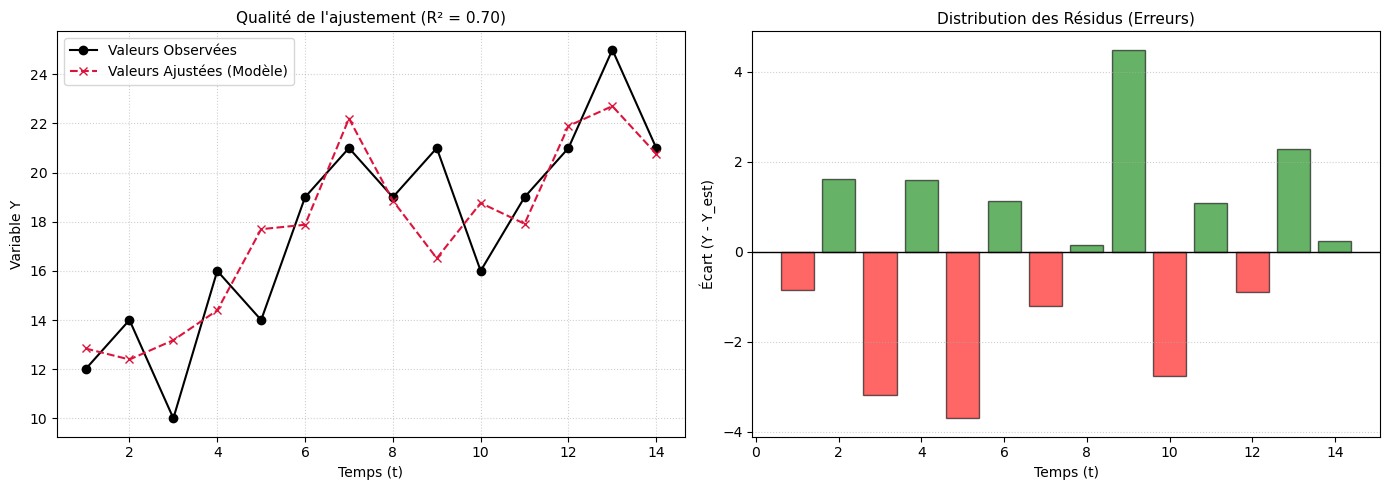

In [14]:
# =============================================================================
# 13. VISUALISATION GRAPHIQUE
# =============================================================================
print("=== 13. Génération des graphiques... ===")

# Création d'une figure avec 2 sous-graphiques (côte à côte)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- GRAPHIQUE 1 : Qualité de l'ajustement (Y obs vs Y pred) ---
ax1.plot(df['t'], Y, color='black', marker='o', label='Valeurs Observées', linewidth=1.5)
ax1.plot(df['t'], Y_est, color='crimson', marker='x', linestyle='--', label='Valeurs Ajustées (Modèle)', linewidth=1.5)

ax1.set_title("Qualité de l'ajustement (R² = {:.2f})".format(r_square), fontsize=11)
ax1.set_xlabel("Temps (t)")
ax1.set_ylabel("Variable Y")
ax1.legend(loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

# --- GRAPHIQUE 2 : Analyse des Résidus (Erreurs) ---
# Un bon modèle doit avoir des résidus dispersés aléatoirement autour de 0
colors = ['green' if r > 0 else 'red' for r in u_residus]
ax2.bar(df['t'], u_residus, color=colors, alpha=0.6, edgecolor='black')
ax2.axhline(0, color='black', linewidth=1)

ax2.set_title("Distribution des Résidus (Erreurs)", fontsize=11)
ax2.set_xlabel("Temps (t)")
ax2.set_ylabel("Écart (Y - Y_est)")
ax2.grid(True, axis='y', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()